Pricing FX options via Heston 
==

This notebook will reproduce the pricing results from STF2hes03.m an appendix to ['FX Smile in the Heston Model'](https://arxiv.org/abs/1010.1617).
Heston pricing does not have a analytical solution. Various numerical methods are available:
1. Original 1993 Heston algorithm integrated with adaptive Gauss-Kronrod quadrature
2. Carr-Madan approach integrated with adaptive Gauss-Kronrod quadrature
3. Fast Fourier Transform 
4. Lipton approach integrated with adaptive Gauss-Kronrod quadrature
5. COS method 

Citation:
Janek, Agnieszka & Kluge, Tino & Weron, Rafał & Wystup, Uwe. (2010). FX Smile in the Heston Model. Statistical Tools for Finance and Insurance. 10.48550/arXiv.1010.1617. 

In [2]:
# -*- coding: utf-8 -*-
import os
if __name__ == "__main__":
    os.chdir(os.environ.get('PROJECT_DIR_FRM'))

import numpy as np
import matplotlib.pyplot as plt
from time import time

from frm.pricing_engine.heston_garman_kohlhagen import \
    heston_carr_madan_price_fx_vanilla_european, \
    heston_cosine_price_fx_vanilla_european, \
    heston1993_price_fx_vanilla_european, \
    heston_lipton_price_fx_vanilla_european

The following data is copied from the MATLAB file 'STF2hes03.m'.  

There have been minor changes to variable names and quoting convetions.

The file was retrieved from [https://ideas.repec.org/c/wuu/hscode/zip10001.html](https://ideas.repec.org/c/wuu/hscode/zip10001.html). The webpage has also been saved to [WaybackMachine](https://web.archive.org/web/20240926111306/https://ideas.repec.org/c/wuu/hscode/zip10001.html)


In [3]:
# Inputs copied from STF2hes03.m which is a support to
# "FX smile in the Heston model" by A Janek, 2010.
# Source: https://ideas.repec.org/c/wuu/hscode/zip10001.html
# WaybackMachine save: 
# https://web.archive.org/web/20240926111306/https://ideas.repec.org/c/wuu/hscode/zip10001.html

S0 = 1.2
tau = 0.5
r_d = 0.022
r_f = 0.018
kappa = 1.5
theta = 0.015
vv = 0.2
rho = 0.05;
lambda_ = 0
var0 = 0.01
K = np.linspace(1.1,1.3,81)

# Tolerances
dp = 7
tol = 1 / (10**dp)

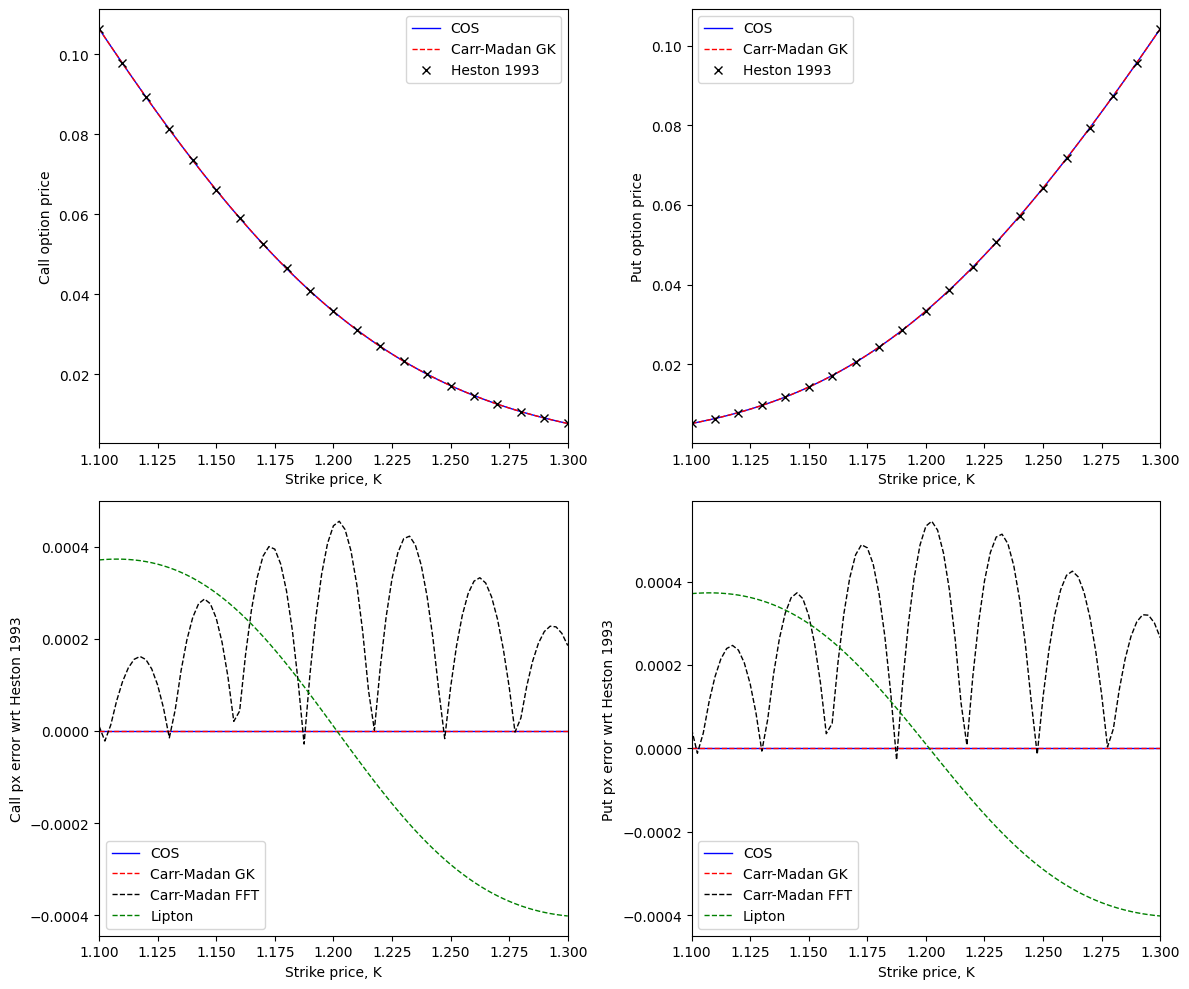

In [4]:
# The COS method is can be applied to multiple strikes (i.e vectorised to multiple strikes)
cp = np.ones(shape=K.shape) 
COS_call = heston_cosine_price_fx_vanilla_european(S0, tau, r_f, r_d, cp, K, var0, vv, kappa, theta, rho, N=160, L=10)
cp = -1 * cp
COS_put = heston_cosine_price_fx_vanilla_european(S0, tau, r_f, r_d, cp, K, var0, vv, kappa, theta, rho, N=160, L=10)


# The original heston 1993 algorithm and the Carr-Madan algorithm require a scalar strike.
heston_1993_call, heston_1993_put = np.empty(K.shape), np.empty(K.shape)
cm_quad_call, cm_quad_put = np.empty(K.shape), np.empty(K.shape)
cm_fft_call, cm_fft_put = np.empty(K.shape), np.empty(K.shape)
lipton_call, lipton_put = np.empty(K.shape), np.empty(K.shape)

for i in range(len(K)):

        # Call options
        cp_ = 1
        heston_1993_call[i] = heston1993_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, lambda_)
        cm_quad_call[i] = heston_carr_madan_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=0)
        cm_fft_call[i] = heston_carr_madan_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=1)
        lipton_call[i] = heston_lipton_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho)
        # COS_call[i] = heston_cosine_price_fx_vanilla_european(S0, tau, r_f, r_d, cp, K[i], var0, vv, kappa, theta, rho, N=160, L=10)
         
        # Put options
        cp_ = -1
        heston_1993_put[i] = heston1993_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, lambda_)
        cm_quad_put[i] = heston_carr_madan_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=0)
        cm_fft_put[i] = heston_carr_madan_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho, integration_method=1)
        lipton_put[i] = heston_lipton_price_fx_vanilla_european(S0, tau, r_f, r_d, cp_, K[i], var0, vv, kappa, theta, rho)
        # COS_put[i] = heston_cosine_price_fx_vanilla_european(S0, tau, r_f, r_d, cp, K[i], var0, vv, kappa, theta, rho, N=160, L=10)        
        

# Calculate errors with respect to the Heston 1993 algorithm. 
error_COS_call = COS_call - heston_1993_call
error_cm_quad_call = cm_quad_call - heston_1993_call
error_cm_fft_call = cm_fft_call - heston_1993_call
error_lipton_call = lipton_call - heston_1993_call

error_COS_put = COS_put - heston_1993_put
error_cm_quad_put = cm_quad_put - heston_1993_put
error_cm_fft_put = cm_fft_put - heston_1993_put
error_lipton_put = lipton_put - heston_1993_put

# Plotting - these plot's match STF2hes03.m
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# First subplot
axs[0, 0].plot(K, COS_call, 'b-', linewidth=1)
axs[0, 0].plot(K, cm_quad_call, 'r--', linewidth=1)
axs[0, 0].plot(K[::4], heston_1993_call[::4], 'kx', linewidth=1)
axs[0, 0].set_xlabel('Strike price, K')
axs[0, 0].set_ylabel('Call option price')
axs[0, 0].legend(['COS', 'Carr-Madan GK', 'Heston 1993'], loc='upper right')
axs[0, 0].set_xlim(min(K), max(K))

# Second subplot
axs[0, 1].plot(K, COS_put, 'b-', linewidth=1)
axs[0, 1].plot(K, cm_quad_put, 'r--', linewidth=1)
axs[0, 1].plot(K[::4], heston_1993_put[::4], 'kx', linewidth=1)
axs[0, 1].set_xlabel('Strike price, K')
axs[0, 1].set_ylabel('Put option price')
axs[0, 1].legend(['COS', 'Carr-Madan GK', 'Heston 1993'], loc='upper left')
axs[0, 1].set_xlim(min(K), max(K))

# Third subplot
axs[1, 0].plot(K, error_COS_call, 'b-', linewidth=1)
axs[1, 0].plot(K, error_cm_quad_call, 'r--', linewidth=1)
axs[1, 0].plot(K, error_cm_fft_call, 'k--', linewidth=1)
axs[1, 0].plot(K, error_lipton_call, 'g--', linewidth=1)
axs[1, 0].set_xlabel('Strike price, K')
axs[1, 0].set_ylabel('Call px error wrt Heston 1993')
axs[1, 0].legend(['COS', 'Carr-Madan GK', 'Carr-Madan FFT','Lipton'], loc='lower left')
axs[1, 0].set_xlim(min(K), max(K))

# Fourth subplot
axs[1, 1].plot(K, error_COS_put, 'b-', linewidth=1)
axs[1, 1].plot(K, error_cm_quad_put, 'r--', linewidth=1)
axs[1, 1].plot(K, error_cm_fft_put, 'k--', linewidth=1)
axs[1, 1].plot(K, error_lipton_put, 'g--', linewidth=1)
axs[1, 1].set_xlabel('Strike price, K')
axs[1, 1].set_ylabel('Put px error wrt Heston 1993')
axs[1, 1].legend(['COS', 'Carr-Madan GK', 'Carr-Madan FFT','Lipton'], loc='lower left')
axs[1, 1].set_xlim(min(K), max(K))

plt.tight_layout()
plt.show()

Per the prior chart, integration with adaptive Gauss-Kronrod quadrature over the original 1993 Heston algorithm or the Carr-Madan approach, or the COS method all produce highly accurate results. 

Let us know inspect the runtime of the methods.

In [5]:
print('Runtime of various Heston pricing methods:')

nb_runs = 100

t1 = time()
for i in range(nb_runs):
    heston_cosine_price_fx_vanilla_european(S0, tau, r_f, r_d, cp, K, var0, vv, kappa, theta, rho, N=160, L=10)
t2 = time()
print("COS method: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston_carr_madan_price_fx_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho, integration_method=0)
t2 = time()
print("Carr-Madan GK: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston_carr_madan_price_fx_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho, integration_method=1)
t2 = time()
print("Carr-Madan FFT: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston_lipton_price_fx_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho)
t2 = time()
print("Lipton: ", round(t2-t1,3))

t1 = time()
for j in range(nb_runs):
    for i in range(len(K)):
        heston1993_price_fx_vanilla_european(S0, tau, r_f, r_d, 1, K[i], var0, vv, kappa, theta, rho)
t2 = time()
print("Heston 1993: ", round(t2-t1,3))

Runtime of various Heston pricing methods:
COS method:  0.131
Carr-Madan GK:  1.337
Carr-Madan FFT:  3.05
Lipton:  1.616
Heston 1993:  6.0


The COS method is materially faster and it is vectorised for the strikes. 